# Rubisco correlations
In tthis notebooks, we'll explore the correlation between the relative abundance of the Rubisco large subunit and the photorespiration and light reaction proteins in our proteomic dataset.

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
import numpy as np

## Read in the data
We'll need the gene lists for photorespiration and light reactions, as well as the proteomics relative abundances. 

In [3]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes_unique.json') as f:
    photo_genes = json.load(f)

In [4]:
normed_intensity = pd.read_csv('../data/proteomics/log2_normalized_intensity_all_proteins.csv', header=63)
normed_intensity['base_accession_num'] = normed_intensity['Accession Number'].str.split('.').str[0].str.lower()
normed_intensity.head()

,#,Visible?,Starred?,Identified Proteins (5236),Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,null,Log? Fold Change by Category,...,Std Dev(40D),2A,Std Dev(2A),2B,Std Dev(2B),2C,Std Dev(2C),2D,Std Dev(2D),base_accession_num
0,1.1,True,Empty,| Symbols: RBCL | ribulose-bisphosphate carbox...,ATCG00490.1,NaN,53 kDa,True,NaN,NaN,...,0.196767,20.93,0.205865,20.93,0.207863,20.99,0.247684,20.99,0.287163,atcg00490
1,2.1,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38410.3,NaN,21 kDa,True,NaN,NaN,...,0.220497,19.69,0.199340,19.64,0.171996,19.68,0.253894,19.63,0.350307,at5g38410
2,3,True,Empty,"| Symbols: ATPB, PB | ATP synthase subunit bet...",ATCG00480.1,NaN,54 kDa,True,NaN,NaN,...,0.175100,21.3,0.183469,21.3,0.176435,21.38,0.220837,21.27,0.236947,atcg00480
3,5.1,True,Empty,| Symbols: RCA | rubisco activase | chr2:16570...,AT2G39730.1,NaN,52 kDa,True,NaN,NaN,...,0.206727,18.85,0.230498,18.8,0.203535,18.96,0.204537,18.94,0.215761,at2g39730
4,2.2,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38430.1,NaN,20 kDa,True,NaN,NaN,...,0.200043,20.34,0.175207,20.28,0.157066,20.32,0.253058,20.2,0.327897,at5g38430


Rename the standard dev columns:

In [5]:
columns_to_rename = {
    n: n.split('(')[1][:-1] + '_std' # Get the sample ID and add std after it
    for n in normed_intensity.columns if 'Std Dev' in n
}

In [6]:
normed_intensity = normed_intensity.rename(columns=columns_to_rename)

In [7]:
normed_intensity.head()

,#,Visible?,Starred?,Identified Proteins (5236),Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,null,Log? Fold Change by Category,...,40D_std,2A,2A_std,2B,2B_std,2C,2C_std,2D,2D_std,base_accession_num
0,1.1,True,Empty,| Symbols: RBCL | ribulose-bisphosphate carbox...,ATCG00490.1,NaN,53 kDa,True,NaN,NaN,...,0.196767,20.93,0.205865,20.93,0.207863,20.99,0.247684,20.99,0.287163,atcg00490
1,2.1,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38410.3,NaN,21 kDa,True,NaN,NaN,...,0.220497,19.69,0.199340,19.64,0.171996,19.68,0.253894,19.63,0.350307,at5g38410
2,3,True,Empty,"| Symbols: ATPB, PB | ATP synthase subunit bet...",ATCG00480.1,NaN,54 kDa,True,NaN,NaN,...,0.175100,21.3,0.183469,21.3,0.176435,21.38,0.220837,21.27,0.236947,atcg00480
3,5.1,True,Empty,| Symbols: RCA | rubisco activase | chr2:16570...,AT2G39730.1,NaN,52 kDa,True,NaN,NaN,...,0.206727,18.85,0.230498,18.8,0.203535,18.96,0.204537,18.94,0.215761,at2g39730
4,2.2,True,Empty,| Symbols: | Ribulose bisphosphate carboxylas...,AT5G38430.1,NaN,20 kDa,True,NaN,NaN,...,0.200043,20.34,0.175207,20.28,0.157066,20.32,0.253058,20.2,0.327897,at5g38430


Drop all columns besides those we're interested in:

In [8]:
normed_intensity = normed_intensity[['21A', '21A_std', '21B', '21B_std', '21C',
       '21C_std', '21D', '21D_std', '40A', '40A_std', '40B', '40B_std', '40C',
       '40C_std', '40D', '40D_std', '2A', '2A_std', '2B', '2B_std', '2C',
       '2C_std', '2D', '2D_std', 'base_accession_num']]

Drop all rows with No data:

In [9]:
normed_intensity = normed_intensity[~normed_intensity.eq('No data').any(axis=1)]

Now we subset the overall df by the protein groups we want:

In [10]:
rubisco = 'ATCG00490'
rubisco_intensity = normed_intensity[normed_intensity['base_accession_num'] == rubisco.lower()]
rubisco_intensity.shape

(1, 25)

In [11]:
photoresp_intensity = normed_intensity[normed_intensity['base_accession_num'].isin(photo_genes['photorespiration'])]
print(f'{photoresp_intensity.shape[0]} of {len(photo_genes["photorespiration"])} photorespiratory genes are represented in the proteomics dataset.')

22 of 24 photorespiratory genes are represented in the proteomics dataset.


In [12]:
light_rxn_intensity = normed_intensity[normed_intensity['base_accession_num'].isin(photo_genes['light_rxns'])]
print(f'{light_rxn_intensity.shape[0]} of {len(photo_genes["light_rxns"])} light reaction genes are represented in the proteomics dataset.')

92 of 114 light reaction genes are represented in the proteomics dataset.


## Wrangle the data

In [13]:
rubisco_T = rubisco_intensity[[c for c in rubisco_intensity.columns if 'std' not in c and c != 'base_accession_num']].T.rename(columns={0: 'rubisco'}).astype('float64')

In [14]:
light_rxn_T = light_rxn_intensity[[c for c in light_rxn_intensity.columns if 'std' not in c and c != 'base_accession_num']].T.rename(columns={i:  'protein_' + bn for i, bn in zip(light_rxn_intensity.index, light_rxn_intensity['base_accession_num'])}).astype('float64')

In [15]:
photoresp_T = photoresp_intensity[[c for c in photoresp_intensity.columns if 'std' not in c and c != 'base_accession_num']].T.rename(columns={i: 'protein_' + bn for i, bn in zip(photoresp_intensity.index, photoresp_intensity['base_accession_num'])}).astype('float64')

## Plot
To start with, I am going to make a separate plot for each gene, and clump the plots together into figures by their group. The shape of the points will be the oxygen concentration.

In [37]:
def close_factors(number):
    ''' 
    find the closest pair of factors for a given number
    From: https://stackoverflow.com/a/77243426
    '''
    factor1 = 0
    factor2 = number
    while factor1 +1 <= factor2:
        factor1 += 1
        if number % factor1 == 0:
            factor2 = number // factor1
        
    return factor1, factor2

def almost_factors(number):
    '''
    find a pair of factors that are close enough for a number that is close enough
    From: https://stackoverflow.com/a/77243426
    '''
    while True:
        factor1, factor2 = close_factors(number)
        if 1/2 * factor1 <= factor2: # the fraction in this line can be adjusted to change the threshold aspect ratio
            break
        number += 1
    return factor1, factor2

def make_rubisco_plots(df_T, rubisco_T, markers, stat_test_res=None):
    """
    Use the above format of data to make plots.
    """
    # Get number of rows and columns and set up figure
    num_plots = len(df_T.columns)
    dim = almost_factors(num_plots)
    figsize = (dim[0]*3, dim[1]*4)
    fig, axs = plt.subplots(*dim, figsize=figsize, sharex=True, sharey=True)

    for ax, col in zip(axs.flat, df_T.columns):

        # Merge the rubisco df with the y df
        together = pd.merge(rubisco_T, df_T[[col]], left_index=True, right_index=True)

        # Get the oxygen concentration for each point
        together['o2'] = together.index.str[:-1]

        # Plot points
        for o2, d in together.groupby('o2'):
            marker = markers[o2]
            ax.scatter(d['rubisco'], d[col], marker=marker, label=f'{o2}% oxygen')
        if stat_test_res is not None:
            color = 'red' if stat_test_res[col] < 0.05 else 'black'
            ax.set_title(col.split('_')[1].upper() + f' p-value: {stat_test_res[col]:.2f}', color=color)
        else:
            ax.set_title(col.split('_')[1].upper())

    num_to_del = dim[0]*dim[1] - num_plots
    [fig.delaxes(ax) for ax in axs.flat[-num_to_del:]]
    
    fig.supylabel('Protein Log2 Normalized Intensity')
    fig.supxlabel('Rubisco Log2 Normalized Intensity')
    plt.subplots_adjust(left=0.05, bottom=0.05)
    plt.legend(bbox_to_anchor=(2, 0.5))

In [17]:
markers = {
    '2': 'P',
    '21': 'X',
    '40': 'H'
}

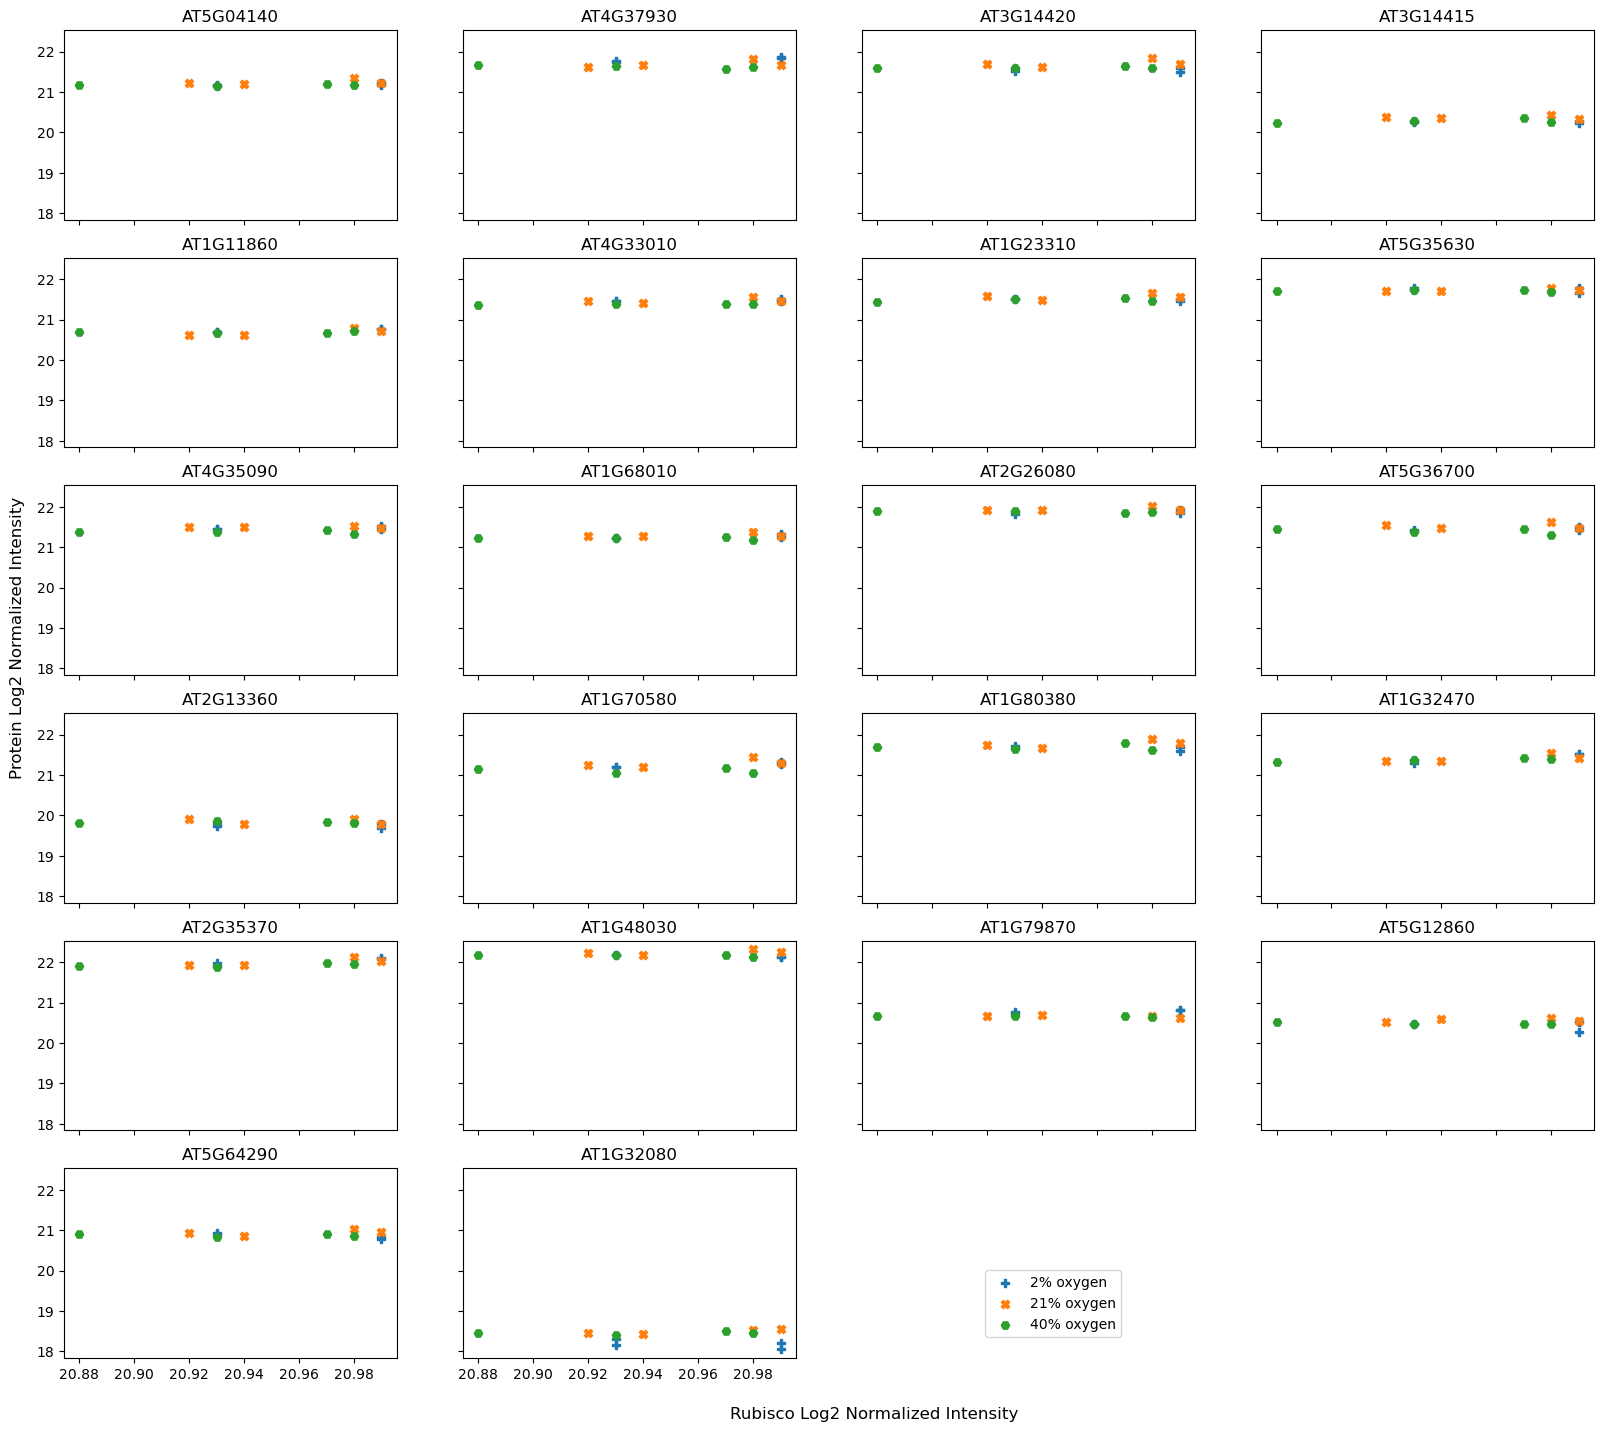

In [18]:
make_rubisco_plots(photoresp_T, rubisco_T, markers)

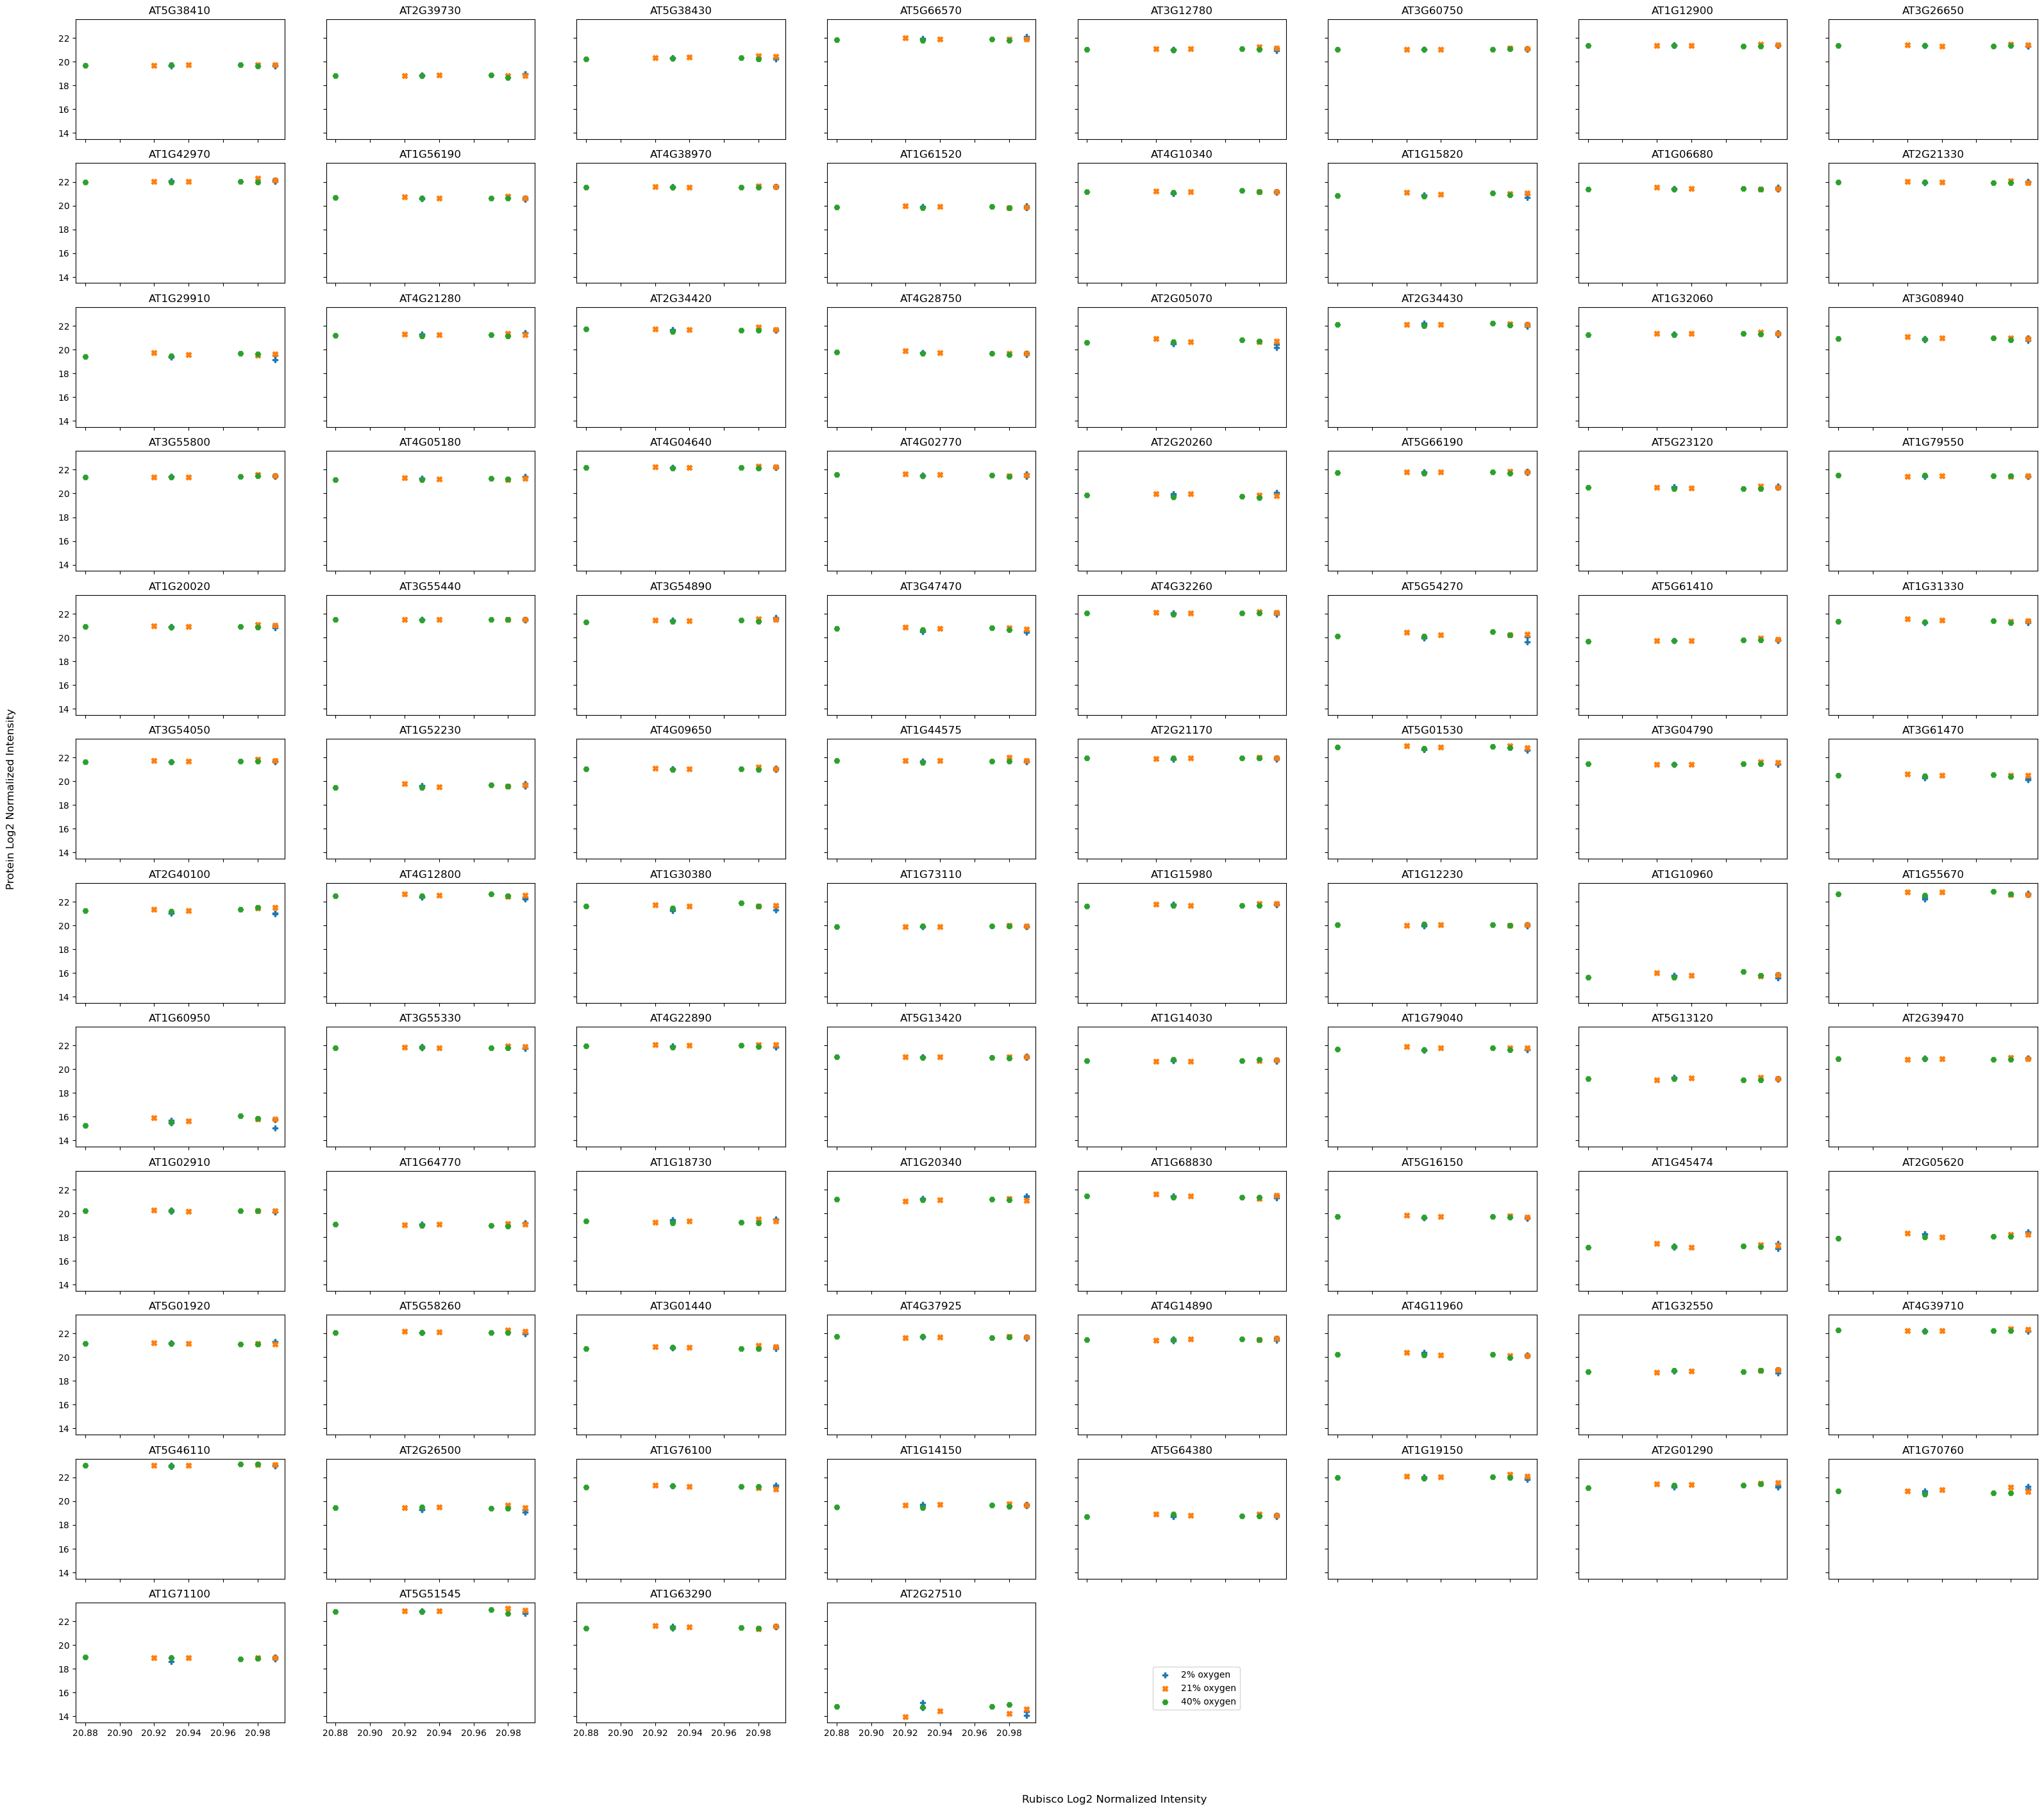

In [19]:
make_rubisco_plots(light_rxn_T, rubisco_T, markers)

## Statistical testing
None of these plots have an obvious linear relationship -- however, we should perform a statistical test to be sure. We'll use a regression F-test from scikit learn, and then regenerate the plots for just those that are significant.

In [38]:
photoresp_f_test, photoresp_p_vals = f_regression(photoresp_T.to_numpy(), rubisco_T.to_numpy().ravel())
photoresp_pvals = {gene: p for gene, p in zip(photoresp_T.columns, photoresp_p_vals)}

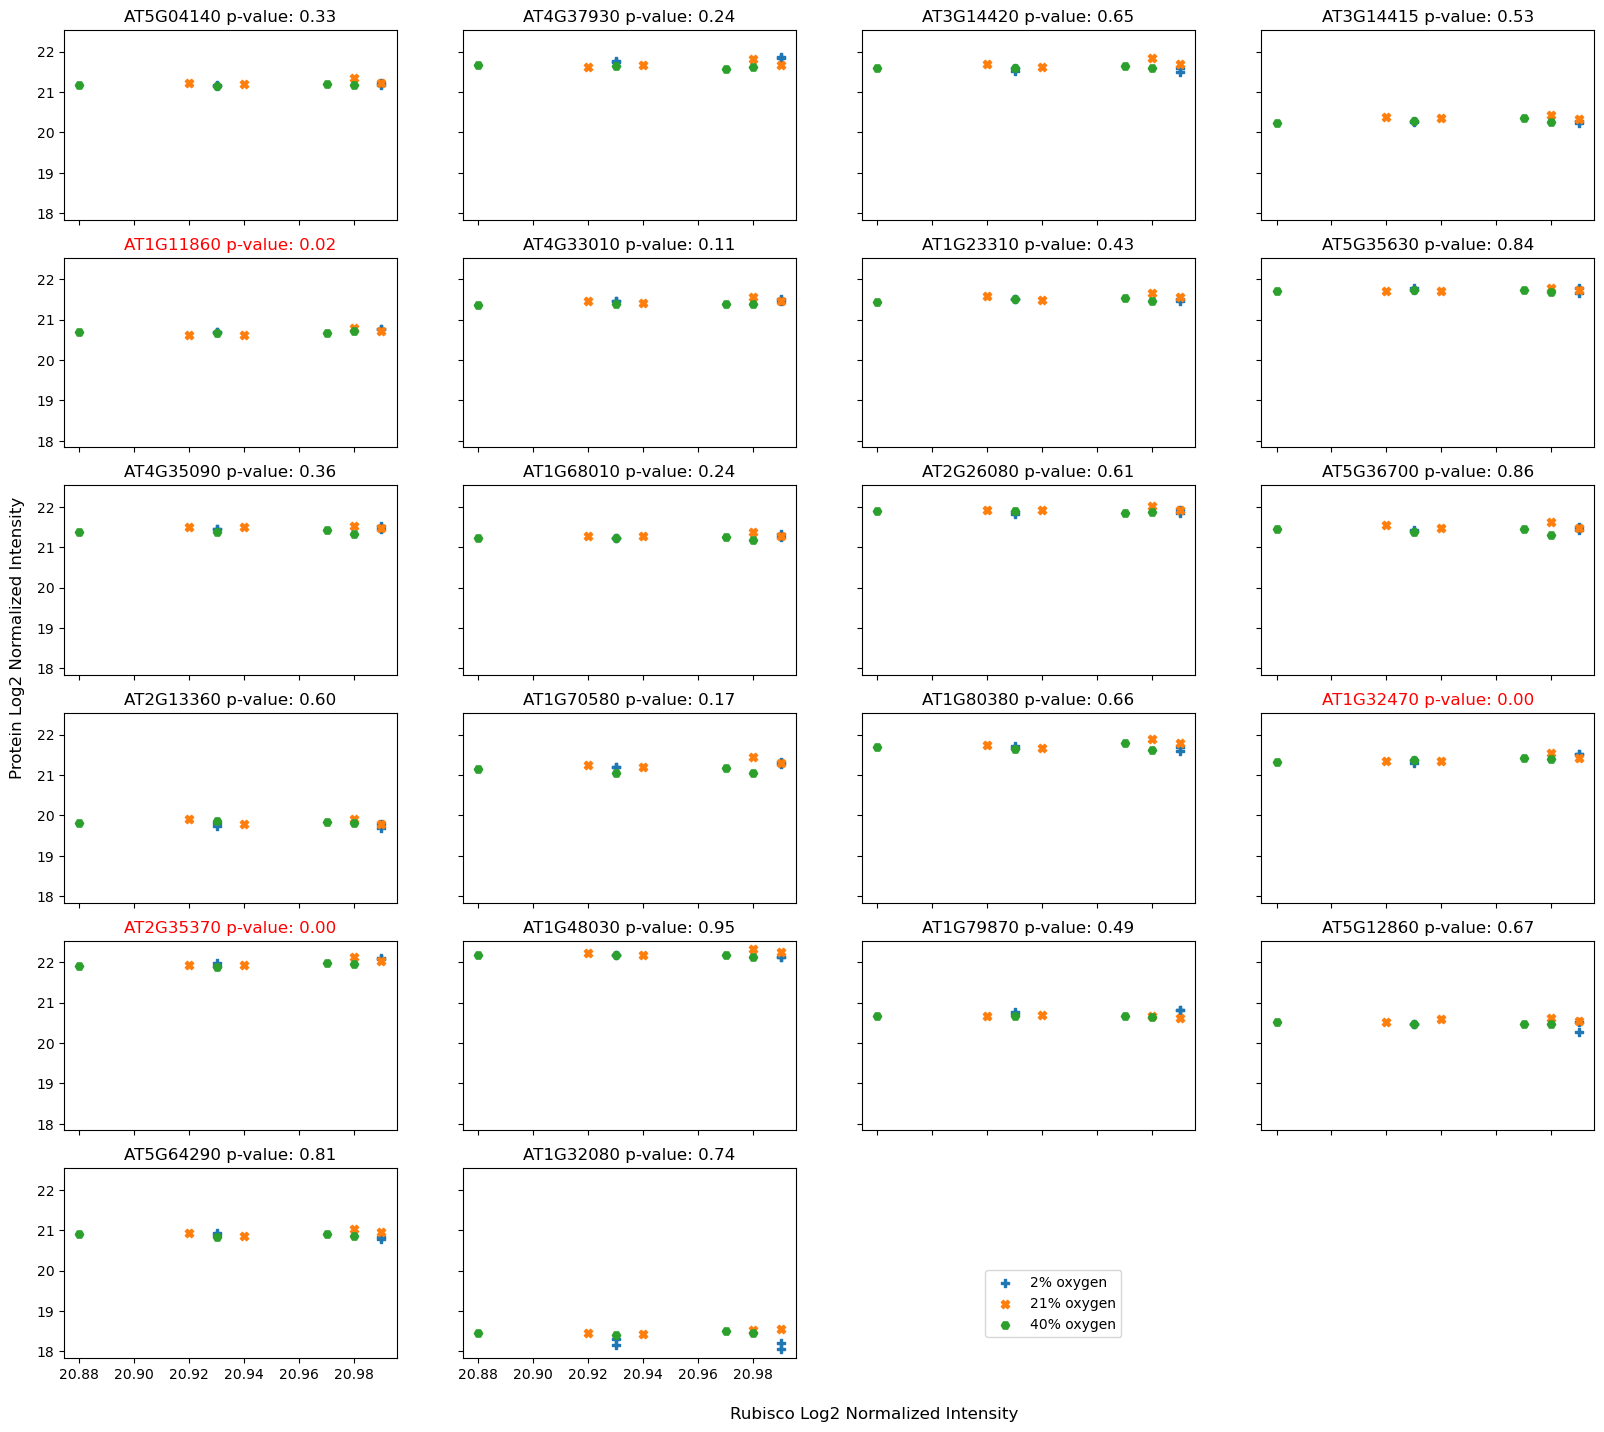

In [39]:
make_rubisco_plots(photoresp_T, rubisco_T, markers, stat_test_res=photoresp_pvals)

In [35]:
light_rxn_f_test, light_rxn_p_vals = f_regression(light_rxn_T.to_numpy(), rubisco_T.to_numpy().ravel())
light_rxn_pvals = {gene: p for gene, p in zip(light_rxn_T.columns, light_rxn_p_vals)}

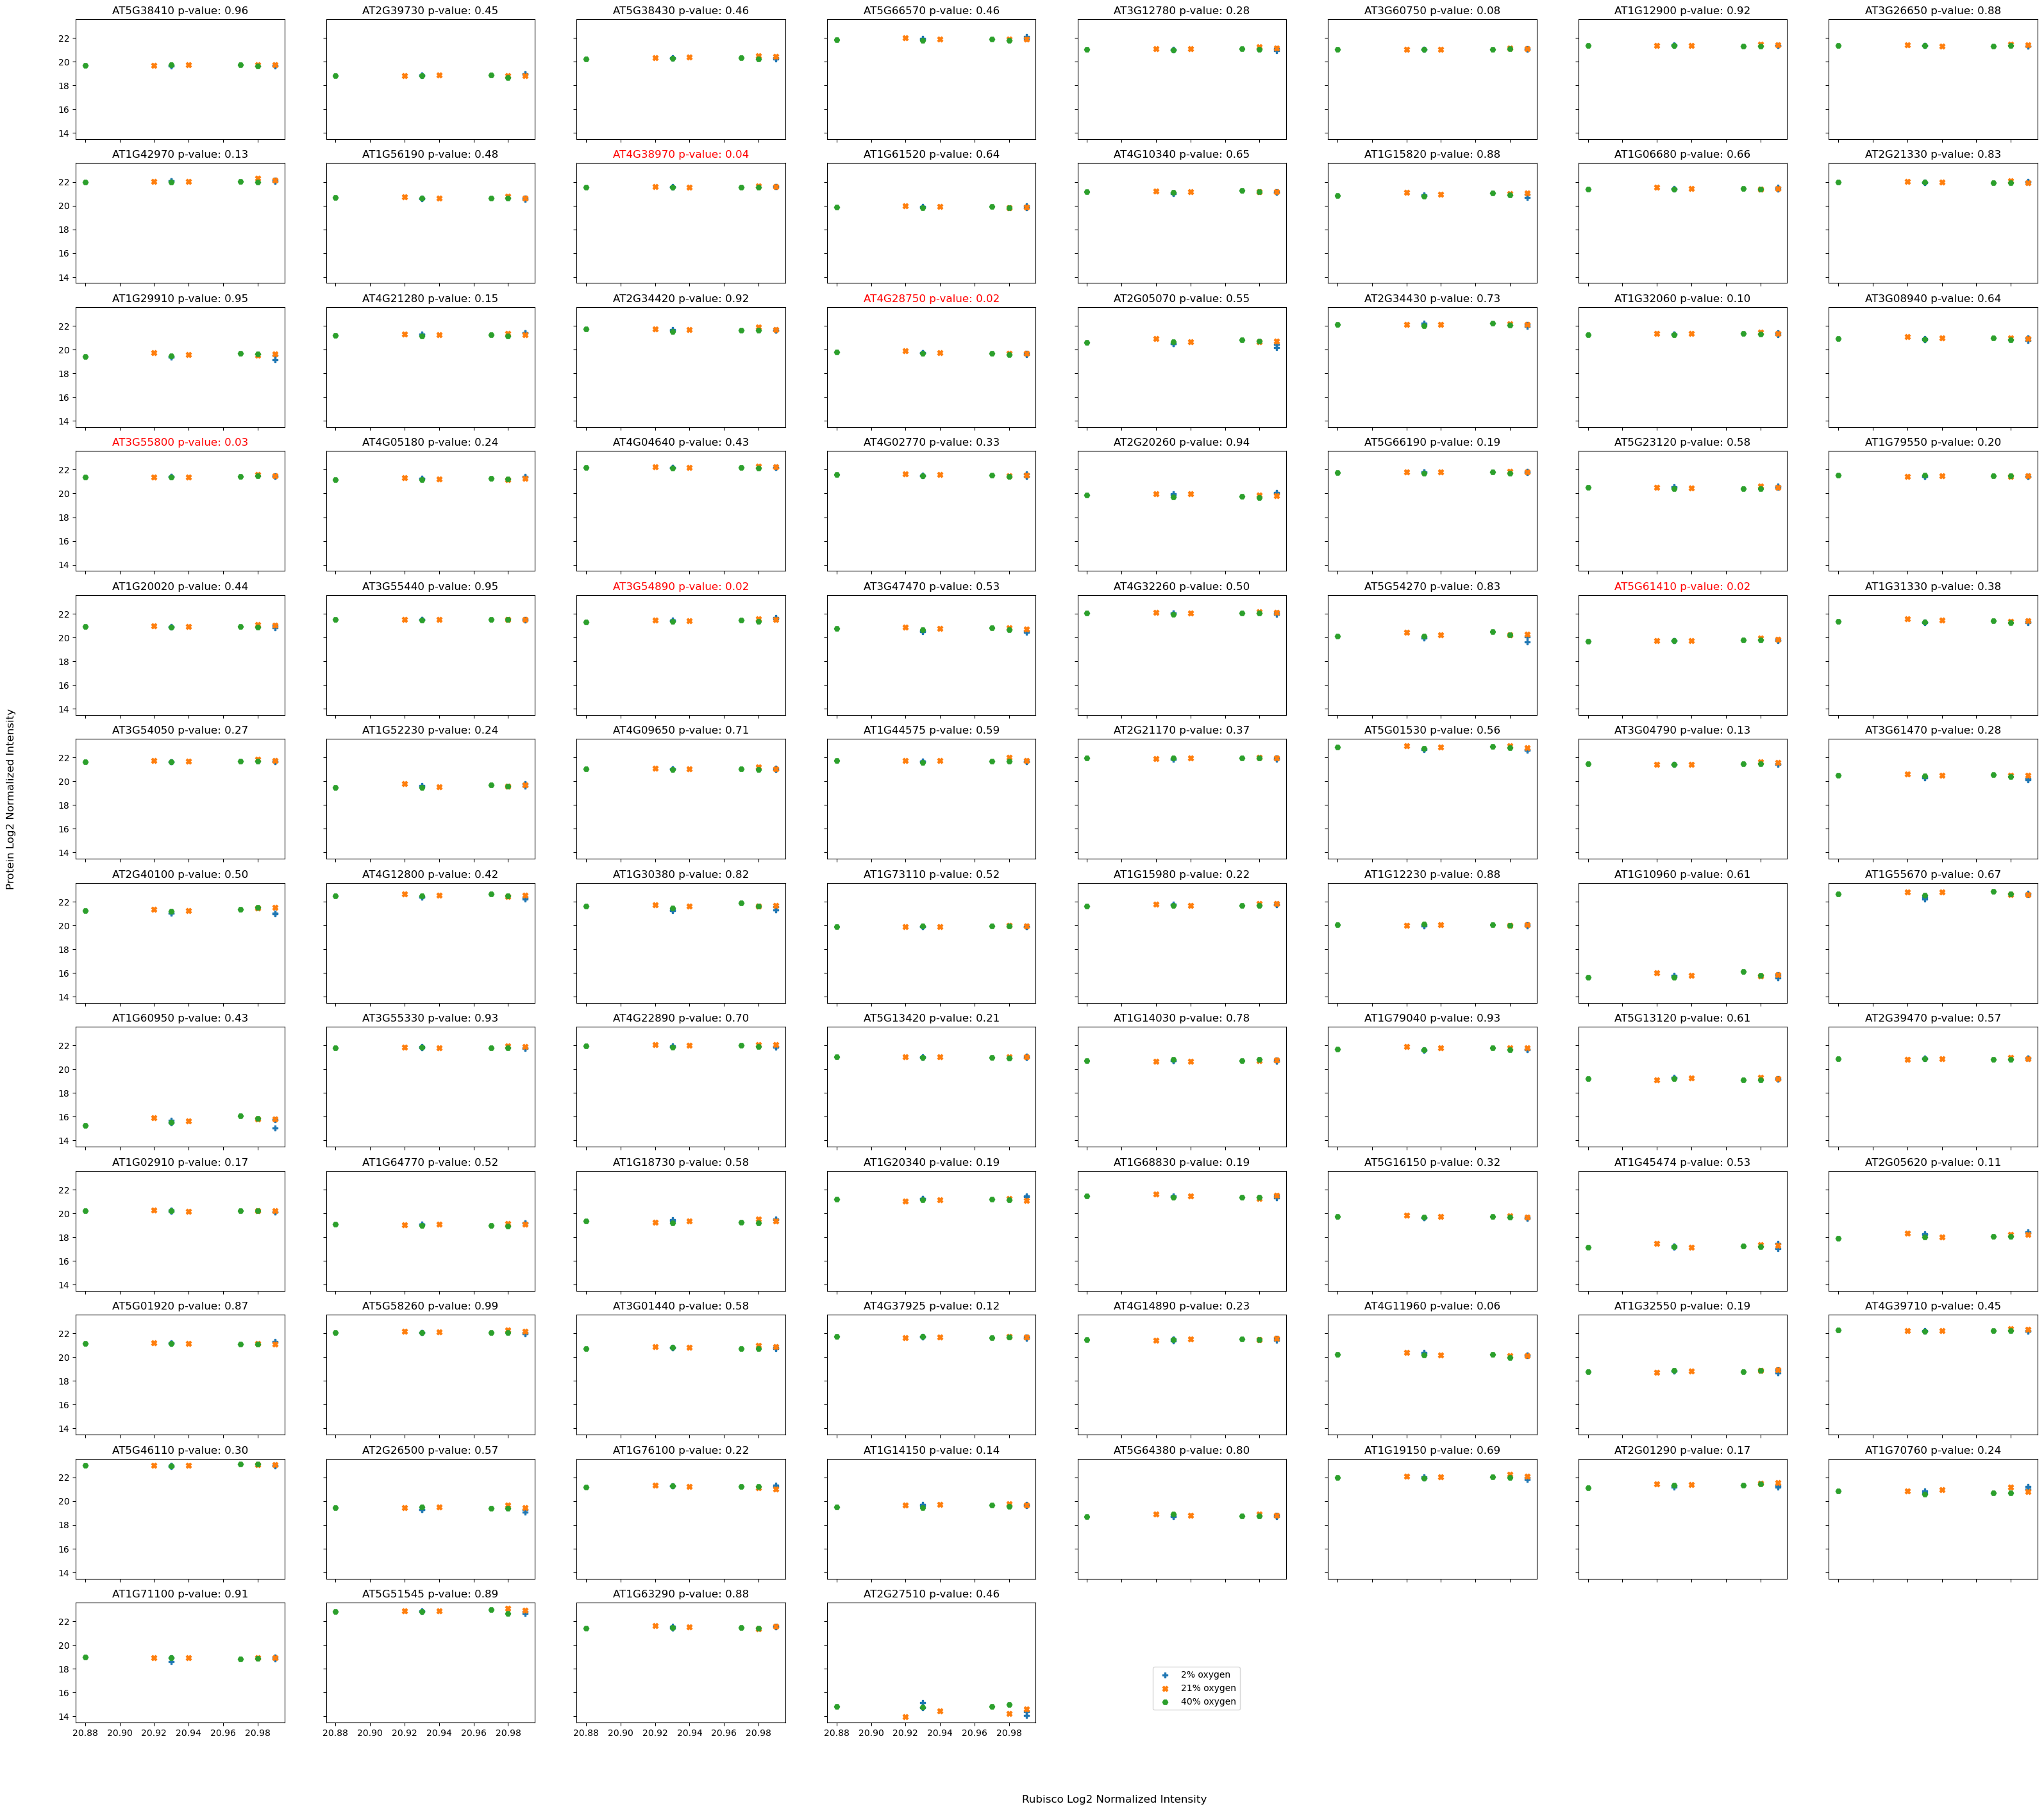

In [40]:
make_rubisco_plots(light_rxn_T, rubisco_T, markers, stat_test_res=light_rxn_pvals)